## **Can RNNs extract information from seismic signals?**

*[See [here](https://www.kaggle.com/michael422/spectrogram-convolution) for a related article on using [Convolutional Neural Networks](https://www.kaggle.com/michael422/spectrogram-convolution) on seismic data.]*

Recurrent neural networks (RNNs) and variants such as long short-term memory ([LSTM](https://arxiv.org/abs/1402.1128)) are used in a range of applications to interpret sequential data.  Here we will use RNNs to try to predict the time of the next simulated earthquake ("labquake") based on the acoustic signals emitted by the laboratory setup.

We use the first 400MM records in order to process efficiently in-memory:

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from functools import partial
import tensorflow as tf
from tqdm import tqdm_notebook, tnrange, tqdm, trange
from scipy import signal
import matplotlib.pyplot as plt
np.warnings.filterwarnings('ignore')

rng = np.random.RandomState(datetime.now().microsecond)

data_path = r'../input'
tf_path = os.path.join(data_path, 'tf')

nrows = 400000000   # 629145480
data = (pd.read_csv(os.path.join(data_path, 'train.csv'),
                    nrows=nrows,
                    dtype={'acoustic_data': np.int16,
                           'time_to_failure': np.float32})
        .values)
print(f'input data shape: {data.shape}')

input data shape: (400000000, 2)


Center and log-scale the raw signal data.

In [2]:
obs = data[:, 0]
obs_mean = obs.mean()

def preprocess_obs(obs, obs_mean):
    obs = obs - obs_mean
    obs = (np.log(obs * np.sign(obs) + 1)) * np.sign(obs)
    return obs

print(f'data recentered about mean={obs_mean:.4f}')
obs = preprocess_obs(obs, obs_mean)
data = np.c_[obs, data[:, 1]]

data recentered about mean=4.5531


Split train and validation data.  Notice the difference in distribution between the two sets.

In [3]:
TRAIN_VAL_SPLIT = 0.75

train_size = int(data.shape[0] * TRAIN_VAL_SPLIT)
train_data = data[:train_size, :]
val_data = data[train_size:, :]

print(f'train mean ttf: {train_data[:, 1].mean():.4f}, ' +
      f'val mean ttf: {val_data[:, -1].mean():.4f}')
print(f'train 1st quartile ttf: {np.quantile(train_data[:, -1], 0.25):.4f}, ' +
      f'val 1st quartile ttf: {np.quantile(val_data[:, -1], 0.25):.4f}')
print(f'train 3rd quartile ttf: {np.quantile(train_data[:, -1], 0.75):.4f}, ' +
      f'val 3rd quartile ttf: {np.quantile(val_data[:, -1], 0.75):.4f}')

train mean ttf: 6.0704, val mean ttf: 5.0970
train 1st quartile ttf: 2.8643, val 1st quartile ttf: 2.2285
train 3rd quartile ttf: 8.7798, val 3rd quartile ttf: 7.4921


The raw signal samples have dimensionality 150,000.  The signals must be reduced to a length that is manageable by an RNN.  We will use a reduced sequence length of 40, which is an integer factor of the test sample length.  Then define a few simple feature extractors that downsample the data by dividing it into frames, returning a sequence of frame-wise aggregates:
1. the range (max - min) of the log amplitudes
1. the 10-90 percentile ranges of log amplitudes (more robust than range)
1. an estimate/proxy for the energy level of the signal, using the sum of the log amplitudes

In [4]:
RAW_SEQ_LEN = 150000
# integer factors: {20, 25, 30, 40, 50, 60, 75, 80, 100, 120, 150}
DSAMP_SEQ_LEN = 40

assert (RAW_SEQ_LEN / DSAMP_SEQ_LEN) % 1 == 0
downsample_rate = int(RAW_SEQ_LEN / DSAMP_SEQ_LEN)

def range_downsample(x, dsamp_rate):
    mat = x.reshape(-1, dsamp_rate).T
    return mat.max(axis=0) - mat.min(axis=0)

def range80_downsample(x, dsamp_rate):
    mat = x.reshape(-1, dsamp_rate).T
    q90 = np.quantile(mat, 0.9, axis=0)
    q10 = np.quantile(mat, 0.1, axis=0)
    return q90 - q10

def energy_downsample(x, dsamp_rate):
    mat = x.reshape(-1, dsamp_rate).T
    return np.fabs(mat).sum(axis=0)

Calculate the mean and standard deviation of the features in order to standardize inputs to model.  We will reframe the full dataset to generate these scaling factors.

In [5]:
def get_scaling_factors(data, dsamp_rate):
    trunc = (len(data) // dsamp_rate) * dsamp_rate
    mat = data[:trunc].reshape((-1, dsamp_rate)).T

    min_ = mat.min(axis=0)
    max_ = mat.max(axis=0)
    range_mean = (max_ - min_).mean()
    range_std = (max_ - min_).std()

    q10 = np.quantile(mat, 0.1, axis=0)
    q90 = np.quantile(mat, 0.9, axis=0)
    range80_mean = (q90 - q10).mean()
    range80_std = (q90 - q10).std()

    energy_mean = np.fabs(mat).sum(axis=0).mean()
    energy_std = np.fabs(mat).sum(axis=0).std()

    return (range_mean, range80_mean, energy_mean,
            range_std, range80_std, energy_std)

range_mean, range80_mean, energy_mean,\
    range_std, range80_std, energy_std =\
    get_scaling_factors(obs, downsample_rate)

print(f'downsampled sequence length: {DSAMP_SEQ_LEN}')
print(f'downsample rate: {downsample_rate}')
print(f'range mean: {range_mean: .4f}, ' +
      f'range sigma: {range_std: .4f}')
print(f'range80 mean: {range80_mean: .4f}, ' +
      f'range80 sigma: {range80_std: .4f}')      
print(f'energy mean: {energy_mean: .4f}, ' +
      f'energy sigma: {energy_std: .4f}')

downsampled sequence length: 40
downsample rate: 3750
range mean:  6.2092, range sigma:  1.3457
range80 mean:  3.4844, range80 sigma:  0.5627
energy mean:  4585.3423, energy sigma:  756.1453


Define a function to retrieve sample features from a sample of raw signal, and a function to generate batches of these samples.

In [6]:
def get_feats(args_in):
    sample_in, dsamp_rate = args_in
    range_ = ((range_downsample(sample_in, dsamp_rate)
                - range_mean)
                / range_std)
    range80 = ((range80_downsample(sample_in, dsamp_rate)
                - range80_mean)
               / range80_std)
    energy = ((energy_downsample(sample_in, dsamp_rate)
               - energy_mean)
              / energy_std)
    return np.c_[range_, range80, energy]


def get_batch(data_in, n_samples, dsamp_rate, seq_len=150000):
    n_rows = data_in.shape[0]
    start_list = [rng.randint(0, n_rows-seq_len)
                  for i in range(n_samples)]
    X = map(get_feats,
            ((data_in[start:start+seq_len, 0], dsamp_rate)
                 for start in start_list))
    y = [data_in[start+seq_len, 1] for start in start_list]
    return list(X), y

Compare the downsampled features with the original log signal.  A lot of information is lost, but the coarse levels of the features correspond to amplitude patterns in the original signal.  Also, the features are very highly correlated.  Either the 10-90 range or the energy would probably be sufficient as a single input to the RNN, but we will use all three features in this demonstration.

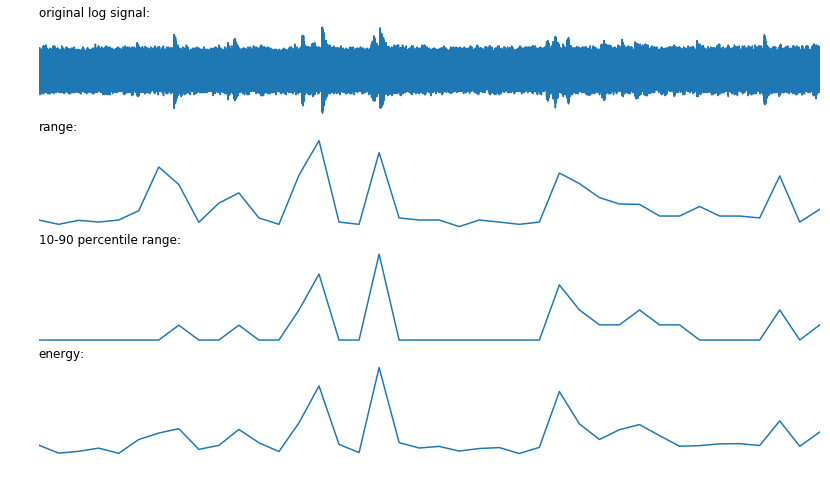

In [7]:
start = 55000000
sig_in = data[start:start+RAW_SEQ_LEN, 0]
feats = get_feats((sig_in, downsample_rate))

data_list = [sig_in] + [feats[:, i] for i in range(3)]
titles = [_ + ':' for _ in ['original log signal', 'range',
                            '10-90 percentile range', 'energy']
         ]

fig = plt.figure(figsize=(14, 8))
for i in range(4):
    ax = fig.add_subplot(4, 1, i+1)
    plt.plot(data_list[i])
    plt.title(titles[i], fontsize=12, loc='left')
    ax.margins(x=0)
    plt.axis('off');

Next, set model parameters.  The primary options are:
1. Number of layers in the RNN
1. Number of hidden dimensions in each RNN layer
1. Forward-only RNN, or bi-directional
1. Type of RNN cell ([LSTM](https://arxiv.org/abs/1402.1128) or [GRU](https://arxiv.org/abs/1412.3555))

After the RNN, we concatenate the final hidden states from each layer into a single 1-dimensional vector, and feed that vector into a densely-connected network.  Using all of the final hidden states preserves multiple levels of extracted features (fine-grained signal information and larger-scale features) to pass into the dense layers.

In the case of a bi-directional RNN, concat the final states from the forward and reverse RNNs into a single vector.

In [8]:
n_features = 3

init_mode = 'FAN_AVG'
init_uniform = True # False for normal init

# RNN config:
dim_h = [256, 256, 256] # dimensions of RNN internal layers
model_type = 'bi'  # {'bi', 'fwd'}: bidirectional or forward-only
cell_type = 'LSTM' # {'LSTM', 'GRU'}
rnn_activation = tf.nn.elu
lstm_use_peepholes = True

# feedforward layers:
dim_ff = [512, 512, 512] # dimensions of feedforward layers
ffn_activation = tf.nn.relu
ffn_drop_rate = 0.2

n_epochs = 2000
eta = 0.000005
train_batch_size = 100
objective = 'MSE'  # {'MSE', 'MAE', 'exp_error'}
optimizer_name = 'adam'# ['sgd', 'adam', 'adagrad', 'adadelta']
eval_batch_size = 100
n_eval_batches = 10
stdout_eval_interval = 100
tensorboard_eval_interval = 20

optimizers = {
    'sgd': tf.train.GradientDescentOptimizer,
    'adam': tf.train.AdamOptimizer,
    'adagrad': tf.train.AdagradOptimizer,
    'adadelta': tf.train.AdadeltaOptimizer
    }

Build the computational graph.

In [9]:
try:
    sess.close()
except: pass

global graph
graph = tf.Graph()
tf.reset_default_graph()
with graph.as_default():

    X = tf.placeholder(tf.float32,
        shape=(None, DSAMP_SEQ_LEN, n_features), name='X')
    y = tf.placeholder(tf.float32, shape=(None), name='y')
    X_r = tf.reverse(X, [1], name='X_reversed')
    train_flag = tf.placeholder_with_default(False, shape=(), name='train_flag')

    init = tf.contrib.layers.variance_scaling_initializer(
        mode=init_mode, uniform=init_uniform)

    if cell_type == 'LSTM':
        cell = partial(tf.nn.rnn_cell.LSTMCell,
                       use_peepholes=lstm_use_peepholes,
                       activation=rnn_activation,
                       initializer=init)

    elif cell_type == 'GRU':
        cell = partial(tf.nn.rnn_cell.GRUCell,
                       activation=rnn_activation,
                       kernel_initializer=init)

    # unroll RNN
    with tf.name_scope('forward_RNN'):
        fwd_cells = [cell(num_units=layer, name='l' + str(i+1) + '_fwd')
                    for i, layer in enumerate(dim_h)]

    with tf.name_scope('reverse_RNN'):
        rev_cells = [cell(num_units=layer, name='l' + str(i+1) + '_rev')
                    for i, layer in enumerate(dim_h)]

    multi_rnn = tf.contrib.rnn.MultiRNNCell(fwd_cells)
    multi_rnn_r = tf.contrib.rnn.MultiRNNCell(rev_cells)

    rnn_out, states = tf.nn.dynamic_rnn(multi_rnn, X, dtype=tf.float32)
    rnn_out_r, states_r = tf.nn.dynamic_rnn(multi_rnn_r, X_r, dtype=tf.float32)

    # concat the final states of each RNN layer
    # rnn_out = batch x seq_len x dim_h
    # states = (layers x (c, h)) x batch x dim_h
    concat_fwd = tf.concat([layer[1] for layer in states], 1)
    concat_rev = tf.concat([layer[1] for layer in states_r], 1)

    # concat the forward and reverse outputs (if bidirectional)
    if model_type == 'bi':
        concat = tf.concat([concat_fwd, concat_rev], 1)
    elif model_type == 'fwd':
        concat = tf.identity(concat_fwd)

    # unroll feedforward layers
    ff_layers = [concat]
    dropout = partial(tf.layers.dropout, rate=ffn_drop_rate, training=train_flag)
    for i, layer in enumerate(dim_ff):
        ff_layers.append(dropout(tf.layers.dense(ff_layers[i], dim_ff[i],
                                                 activation=ffn_activation,
                                                 name='feedforward_' + str(i+1))))

    outputs = tf.layers.dense(ff_layers[-1], 1, name='outputs')

    MAE = tf.reduce_mean(tf.abs(outputs - y))
    MSE = tf.reduce_mean(tf.square(outputs - y))
    exp_error = tf.reduce_mean(tf.subtract(tf.exp(tf.abs(outputs - y)), 1))

    optimizer_fn = optimizers[optimizer_name]

    if objective == 'MAE':
        training_op = optimizer_fn(learning_rate=eta).minimize(MAE)
    elif objective == 'MSE':
        training_op = optimizer_fn(learning_rate=eta).minimize(MSE)
    elif objective == 'exp_error':
        training_op = optimizer_fn(learning_rate=eta).minimize(exp_error)

    with tf.name_scope('MAE'):
        train_mae = tf.summary.scalar('train', MAE)
        val_mae = tf.summary.scalar('val', MAE)
    with tf.name_scope('MSE'):
        train_mse = tf.summary.scalar('train', MSE)
        val_mse = tf.summary.scalar('val', MSE)

    init = tf.global_variables_initializer()

Train and evaluate the model.

In [10]:
sess = tf.InteractiveSession(graph=graph)
init.run(session=sess)

for epoch in tnrange(n_epochs):
    X_train, y_train = get_batch(
        train_data, train_batch_size, downsample_rate, RAW_SEQ_LEN)
    sess.run(training_op, feed_dict={X:X_train, y:y_train, train_flag:True})
    if (epoch+1) % stdout_eval_interval == 0:
        evals_out = {'train': {'mse': [], 'mae': []}, 'eval': {'mse': [], 'mae': []}}
        for i in range(n_eval_batches):
            X_train_batch, y_train_batch = get_batch(
                train_data, train_batch_size, downsample_rate, RAW_SEQ_LEN)
            evals_out['train']['mse'].append(MSE.eval(
                feed_dict={X: X_train_batch, y: y_train_batch, train_flag:False}))
            evals_out['train']['mae'].append(MAE.eval(
                feed_dict={X: X_train_batch, y: y_train_batch, train_flag:False}))
            X_val_batch, y_val_batch = get_batch(
                val_data, eval_batch_size, downsample_rate, RAW_SEQ_LEN)
            evals_out['eval']['mse'].append(MSE.eval(
                feed_dict={X: X_val_batch, y: y_val_batch, train_flag:False}))
            evals_out['eval']['mae'].append(MAE.eval(
                feed_dict={X: X_val_batch, y: y_val_batch, train_flag:False}))
        print(f"round {epoch+1} " +
              f"train MSE: {sum(evals_out['train']['mse'])/n_eval_batches:.4f} " +
              f"train MAE: {sum(evals_out['train']['mae'])/n_eval_batches:.4f} " +
              f"val MSE: {sum(evals_out['eval']['mse'])/n_eval_batches:.4f} " +
              f"val MAE: {sum(evals_out['eval']['mae'])/n_eval_batches:.4f} ")

round 100 train MSE: 47.8309 train MAE: 5.5738 val MSE: 34.6843 val MAE: 4.8000 
round 200 train MSE: 37.7047 train MAE: 4.9203 val MSE: 27.6358 val MAE: 4.0837 
round 300 train MSE: 25.4760 train MAE: 3.9812 val MSE: 15.9003 val MAE: 3.2704 
round 400 train MSE: 22.7982 train MAE: 3.8079 val MSE: 14.1406 val MAE: 3.0763 
round 500 train MSE: 20.2086 train MAE: 3.6258 val MSE: 12.7854 val MAE: 2.9298 
round 600 train MSE: 18.3226 train MAE: 3.4506 val MSE: 12.7609 val MAE: 2.9585 
round 700 train MSE: 18.9698 train MAE: 3.5122 val MSE: 12.7034 val MAE: 2.9555 
round 800 train MSE: 18.8971 train MAE: 3.5013 val MSE: 13.8188 val MAE: 3.0128 
round 900 train MSE: 17.8651 train MAE: 3.3986 val MSE: 12.8971 val MAE: 2.9391 
round 1000 train MSE: 18.1197 train MAE: 3.4730 val MSE: 11.7442 val MAE: 2.8292 
round 1100 train MSE: 17.3262 train MAE: 3.4093 val MSE: 11.4931 val MAE: 2.8024 
round 1200 train MSE: 17.0193 train MAE: 3.3976 val MSE: 12.6190 val MAE: 2.8763 
round 1300 train MSE: 16.

In [11]:
test_path = os.path.join(data_path, 'test')
files = os.listdir(test_path)
print('total files', len(files)) # 2624
preds = {'seg_id': [], 'time_to_failure': []}
for fname in tqdm_notebook(files[:10]):
    path = os.path.join(test_path, fname)
    obs = pd.read_csv(path).values.ravel()
    obs = preprocess_obs(obs, obs_mean)
    feats = get_feats((obs, downsample_rate)).reshape((1, DSAMP_SEQ_LEN, n_features))
    pred = float(outputs.eval(feed_dict={X:feats}))
    preds['time_to_failure'].append(pred)
    preds['seg_id'].append(fname.split('.')[0])
preds_df = pd.DataFrame(preds)
preds_df.shape

total files 2624


(10, 2)

In [12]:
preds_df.to_csv('submissions.csv', index=False)